# Subsampling Markov chain Monte Carlo
## Accompanying notebook to Quiroz and Tran (2023)

This Jupyter notebook contains the implementation of subsampling MCMC that complements Quiroz and Tran (2023), Bayesian Analysis of Big Data via Subsampling Markov Chain Monte Carlo.

The Jupyter notebook illustrates the methodology for a Poisson regression model.


## 1. Prerequisites for running the code 
The demonstration starts in Section 2. This section will install and import modules, and define some auxiliary functions that will be useful.
### 1.1 Install modules
Run the two cells below to install these packages if you do not have them already. You may have to restart the kernel to use the updated packages.

In [10]:
%%capture
pip install autograd

In [11]:
%%capture
pip install pymc3

In [12]:
%%capture
pip install numpy==1.21.6

### 1.2 Import modules
Run the cell below to import the relevant modules and functions for this demonstration.

In [13]:
# Import modules
import matplotlib, time, copy
import matplotlib.pyplot as plt
import autograd.numpy as np
import autograd.scipy.stats as sps_autograd
from autograd import grad, hessian
import scipy.stats as sps
from scipy.optimize import minimize
from pymc3 import ess as effective_sample_size
import statsmodels.api as sm

## 2. Model and data
### 2.1 Example model

The Poisson regression model is useful for modeling the probability distribution of count data $y\in \mathbb{Z}_{\geq 0}$ as a function of a set of explanatory variables $\boldsymbol{x}\in \mathbb{R}^d$. One possible application is modeling the number of hospital visits of an individual as a function of variables such as age, distance to closest hospital, socio-economic variables, etc. 

We consider the model 
\begin{eqnarray*}
 y_{k} & \sim & \mathrm{Poisson}\left(\exp\left(\boldsymbol{\beta}^\top\boldsymbol{x}_k\right)\right), k = 1,\dots, n,\\
 \boldsymbol{\beta} & \sim & \mathcal{N}(\boldsymbol{0}, 10^2\boldsymbol{I}).
\end{eqnarray*}
With $\boldsymbol{\theta} = \boldsymbol{\beta}$, the density of a single observation is
\begin{eqnarray*}
 p(y_{k}|\boldsymbol{\theta}) & = &  \frac{\exp\left(y_k\boldsymbol{\theta}^\top\boldsymbol{x}_k\right)\exp\left(-\exp\left(\boldsymbol{\theta}^\top\boldsymbol{x}_k\right)\right)}{y_k!},
\end{eqnarray*}
and
\begin{eqnarray*}
 \ell_k(\boldsymbol{\theta})= \log p(y_{k}|\boldsymbol{\theta}) & = &  y_k \boldsymbol{\theta}^\top\boldsymbol{x}_k -\exp\left(\boldsymbol{\theta}^\top\boldsymbol{x}_k\right) - \log(y_k!).
\end{eqnarray*}
The following code implements the log-density. 

In [14]:
def log_density(theta, y, X):
    """
    Computes the log-density of the Poisson model evaluated at theta for each of the observations in y, X.
    """
    beta = theta
    return sps_autograd.poisson.logpmf(y, np.exp(np.dot(X, beta)))

### 2.2 Example data
We will use simulated data in this demonstration.

The simulation setting uses $d=10$ parameters, with the true parameter vector being
$$\boldsymbol{\theta}_0 = (4.30, 1.60, -1.06,  0.77,  2.37, -0.14, -0.81, -0.67,  0.45, -0.98)^\top.$$
The first effect corresponds to an intercept (so that the corresponding covariate is $x=1$). The covariates $x$ (excluding the intercept) should be correlated to more resemble real data. We can achieve this by simulating them from a $\mathcal{N}\left(\boldsymbol{0}, \boldsymbol{\widetilde{\Sigma}}\right)$ distribution, where $\boldsymbol{\widetilde{\Sigma}} \sim \mathrm{Wishart}(I, \nu)$ with $I$ being the (9 dimensional) identity matrix and $\nu  = 11$ degrees of freedom. We rescale the resulting $X$ to ensure values of $y$ are not too large.

In [15]:
# Code to simulate data for the Poisson regression model
n = 10000 # Set number of observations.

def simulate_Poisson_data(n):
    np.random.seed(10)    
    beta0 = np.array([4.30, 1.60, -1.06,  0.77,  2.37, -0.14, -0.81, -0.67,  0.45, 0.98])
    Sigma_tilde = sps.wishart.rvs(df = 9, scale = np.eye(9), size = 1)
    X = np.random.multivariate_normal(np.zeros(9), Sigma_tilde, size = n)
    X = np.sqrt(0.1)*(X - np.mean(X))/np.sqrt(np.var(X, axis = 0))
    X = np.hstack((np.ones((n, 1)), X)) # add intercept
    y = sps.poisson.rvs(np.exp(np.dot(X, beta0))) 
    theta0 = beta0
    return((y, X, theta0))

y, X, theta0 = simulate_Poisson_data(n)

print(theta0)
d = len(theta0) # dimension of parameter vector. 


[ 4.3   1.6  -1.06  0.77  2.37 -0.14 -0.81 -0.67  0.45  0.98]


### 2.3 Optimisation
We now perform optimisation to find the maximum likelihood estimate (MLE) that will be used for constructing the control variates. It is a good practice to check that the MLE recovers the true parameters (within the confidence interval obtained by the observed Fisher information). This ensures that the log-density is correctly coded. 

To carry out this task efficiently, the gradient and Hessian of the log-likelihood are useful. We can use automatic differentiation to compute these quantities, avoiding the need of deriving them by hand. In this demonstration, we will use autograd to perform automatic differentiation of the log-likelihood and the log-density. The latter is needed to construct the control variates of the subsampling algorithm in Section 4. For autograd to work, **we need to make sure that the mathematical functions we use are from the autograd package**. This is why we at the beginning of the worksheet used *'from autograd import numpy as np'* instead of the more common *'import numpy as np'*.

The following code maximises the log-likelihood and constructs confidence intervals using the observed Fisher information for the model specified above.

In [16]:
obj_func_likelihood = lambda param: -np.sum(log_density(param, y, X)) # Maximise log-likelihood is the same
                                                                              # as minimize negative log-likelihood
grad_obj_func_likelihood = grad(obj_func_likelihood) # Gradient of obj_func_likelihood. Computed by automatic differentiation
Hess_obj_func_likelihood = hessian(obj_func_likelihood) # Hessian of obj_func_likelihood. Computed by automatic differentiation

# Optimise the log-likelihood to see if we recover true parameters
theta_optim_start = np.zeros(10)
res_optim_likelihood = minimize(obj_func_likelihood, theta_optim_start, method='BFGS', jac=grad_obj_func_likelihood, 
                                options={'gtol': 1e-04, 'maxiter': 1000, 'disp': True})

# Compare answers
print('True parameter values')
print(theta0)
print('MLE estimates')
MLE = res_optim_likelihood.x
print(np.round(MLE, 2))
print('95% Confidence intervals for MLE estimates for Poisson model')
Cov = np.linalg.inv(Hess_obj_func_likelihood(MLE)) # Negative Hessian inverse evaluated at the mode
print(np.round(list(MLE - 1.96*np.sqrt(np.diag(Cov))), 2))
print(np.round(list(MLE + 1.96*np.sqrt(np.diag(Cov))), 2))

         Current function value: 35682.160491
         Iterations: 23
         Function evaluations: 34
         Gradient evaluations: 34
True parameter values
[ 4.3   1.6  -1.06  0.77  2.37 -0.14 -0.81 -0.67  0.45  0.98]
MLE estimates
[ 4.3   1.59 -1.05  0.78  2.37 -0.13 -0.81 -0.67  0.44  0.99]
95% Confidence intervals for MLE estimates for Poisson model
[ 4.3   1.56 -1.07  0.76  2.36 -0.15 -0.83 -0.69  0.42  0.98]
[ 4.3   1.61 -1.04  0.8   2.39 -0.12 -0.79 -0.65  0.46  1.  ]


## 3. The Metropolis-Hastings sampler
In this part of the notebook, we will implement a Metropolis-Hastings sampler using the full data to sample from the posterior distribution. This will serve as the ground truth to compare the subsampling MCMC results against.

### 3.1 The log-likelihood and prior
The Metropolis-Hastings algorithm requires evaluation of the log-posterior (up to a proportionality constant), which is the log-likelihood plus the log-prior.

The following code implements the log-prior and log-likelihood.

In [17]:
def log_prior(theta):
    """
    Simple indepent normal prior with mean 0 and variance 10^2
    """
    return np.sum(sps_autograd.norm.logpdf(theta, 0, 10**2)) 

def log_likelihood(theta, y, X):
    """
    Log-likelihood for the model
    """
    return np.sum(log_density(theta, y, X))

### 3.2 The Metropolis-Hastings sampler
We now sample the posterior distribution using the Metropolis-Hastings sampler with a random walk proposal. For optimality of the random walk, we scale the proposal covariance by $\frac{2.38^2}{d}$, where $d$ is the number of parameters$^2$ .

<sub>$^2$: Gelman, A., Gilks, W. R., and Roberts, G. O. (1997). Weak convergence and optimal scaling of random walk Metropolis algorithms. *The Annals of Applied Probability*, 7(1):110-120.
    
The following code implements the Metropolis-Hastings algorithm to sample from the posterior distribution of the model above.

         Current function value: 35737.403110
         Iterations: 23
         Function evaluations: 34
         Gradient evaluations: 34
True parameter values
[ 4.3   1.6  -1.06  0.77  2.37 -0.14 -0.81 -0.67  0.45  0.98]
MAP estimate
[ 4.3   1.59 -1.05  0.78  2.37 -0.13 -0.81 -0.67  0.44  0.99]
MCMC with random walk proposal for the Poisson regression model with n = 10000
Iteration i = 1000. Acceptance prob (mean) 0.27. Time: 1.57
Iteration i = 2000. Acceptance prob (mean) 0.26. Time: 3.20
Iteration i = 3000. Acceptance prob (mean) 0.26. Time: 4.39
Iteration i = 4000. Acceptance prob (mean) 0.26. Time: 5.71
Iteration i = 5000. Acceptance prob (mean) 0.26. Time: 7.18
Iteration i = 6000. Acceptance prob (mean) 0.26. Time: 8.69
Iteration i = 7000. Acceptance prob (mean) 0.26. Time: 10.08
Iteration i = 8000. Acceptance prob (mean) 0.26. Time: 11.34
Iteration i = 9000. Acceptance prob (mean) 0.26. Time: 12.69
Iteration i = 10000. Acceptance prob (mean) 0.26. Time: 13.98
Iteration i = 11000

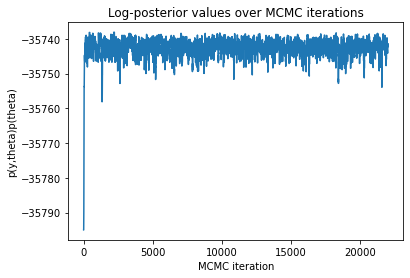

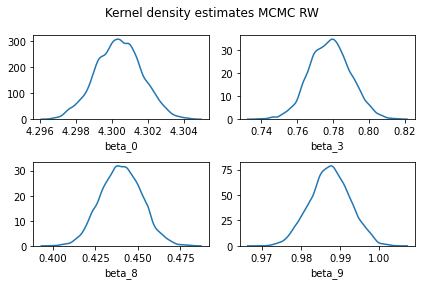

In [18]:
# Define the log-posterior
log_posterior = lambda theta: log_likelihood(theta, y, X) + log_prior(theta) 
obj_func_posterior = lambda theta: -log_posterior(theta) # For maximisation purpose
grad_obj_func_posterior = grad(obj_func_posterior) # Gradient of obj_func_posterior. Computed by automatic differentiation
Hess_obj_func_posterior  = hessian(obj_func_posterior) # Hessian of obj_func_posterior. Computed by automatic differentiation

# Find starting values by optimising the log-posterior
theta_optim_start = np.zeros(10)
res_optim_posterior = minimize(obj_func_posterior, theta_optim_start, method='BFGS', jac=grad_obj_func_posterior, options={'gtol': 1e-04, 'maxiter': 1000, 'disp': True})

# Compare answers
print('True parameter values')
print(theta0)
print('MAP estimate')
MAP = res_optim_posterior.x
print(np.round(MAP, 2))
thetaStar = MAP # Save for computing the control variate later
Sigma_pi = np.linalg.inv(Hess_obj_func_posterior(MAP)) # Negative Hessian inverse evaluated at the mode
PropCov = 2.38**2/d*Sigma_pi # Negative Hessian inverse evaluated at the mode

# Ready for Metropolis-Hastings sampling
N = 22000 # MCMC samples

# Storage
theta_init = MAP + sps.norm.rvs(0, 0.01, len(MAP))
samples = np.zeros((N + 1, d))
samples[0, :] = theta_init
log_p_samples = np.zeros(N + 1)
log_p_samples[0] = log_posterior(theta_init)
alphas = np.zeros(N)

# Current parameter and evaluate quantities
theta_c = theta_init      
log_post_c = log_posterior(theta_c)

tic = time.time()
print('MCMC with random walk proposal for the Poisson regression model with n = %s' % n)
for i in range(1, N + 1):

    if i % 1000 == 0:
        print("Iteration i = {}. Acceptance prob (mean) {:.2f}. Time: {:.2f}".format(i , np.mean(alphas[:i]), time.time() - tic))

    # Propose parameter and evaluate quantities
    theta_p = np.random.multivariate_normal(theta_c, PropCov, size = 1).flatten() # flatten() to get 1-dim array     
    log_post_p = log_posterior(theta_p)
    log_q_p = sps.multivariate_normal.logpdf(theta_p, mean = theta_c, cov = PropCov) # log-proposal density. Symmetric (cancels), but leave for completeness           
    log_q_c = sps.multivariate_normal.logpdf(theta_c, mean = theta_p, cov = PropCov)   
    
    alpha = np.min([1, np.exp(log_post_p - log_q_p - (log_post_c - log_q_c))])
    alphas[i - 1] = alpha
    if np.random.rand() < alpha: # sample Unif(0, 1) to determine acceptance
        samples[i, :] = theta_p
        log_p_samples[i] = log_post_p 
        # Proposed becomes current in next iteration
        theta_c, log_post_c, log_q_c = theta_p, log_post_p, log_q_p
    else:
        samples[i, :] = theta_c 
        log_p_samples[i] = log_post_c 

matplotlib.rc('text', usetex = False)
fig, ax = plt.subplots()
ax.plot(log_p_samples)
ax.set(xlabel='MCMC iteration', ylabel= 'p(y,theta)p(theta)' , 
       title= 'Log-posterior values over MCMC iterations')

# Use 2000 as burn-in
samples = samples[2000:] 
samples_RW = samples # Save the samples from the random walk for future comparisons. 

# Effective sample size and inefficiency factors
ESS = np.zeros(samples.shape[1])
for j in range(samples.shape[1]):
    ESS[j] = effective_sample_size(samples[:, j])    
IF = samples.shape[0]/ESS
IF_MCMC_RW = IF # Save for comparing to subsampling MCMC later

print("Mean ESS: {:.2f}. Median ESS: {:.2f}. Min ESS: {:.2f}. Max ESS: {:.2f}".format(np.mean(ESS), np.median(ESS), np.min(ESS), np.max(ESS)))
print("Mean IF : {:.2f}. Median IF : {:.2f}. Min IF : {:.2f}. Max IF : {:.2f}".format(np.mean(IF), np.median(IF), np.min(IF), np.max(IF)))

# KDE estimates for selected four parameters (0, 1, ... , d - 1)
params_to_plot = [0, 3, 8, 9]
assert(len(params_to_plot) == 4)
param_names = ['beta_%s' % item for item in range(d)]

fig, axs = plt.subplots(2, 2)
fig.suptitle('Kernel density estimates MCMC RW')
k = 0
for i in range(2):
    for j in range(2):
        min_x = np.min(samples[:, params_to_plot[k]])
        max_x = np.max(samples[:, params_to_plot[k]])
        x_grid = np.linspace(min_x, max_x, 500)
        kde = sm.nonparametric.KDEUnivariate(samples[:, params_to_plot[k]]) # kernel density for each parameter
        kde.fit() 
        axs[i, j].plot(kde.support, kde.density)
        axs[i, j].set_ylim(ymin = 0)
        axs[i, j].set(xlabel = param_names[params_to_plot[k]])
        k = k + 1
        
fig.tight_layout()        
fig.subplots_adjust(top=0.88)
plt.show()



In [19]:
def initiate_control_variate_quantities(log_density, y, X, thetaStar):
    """
    Creates the quantities needed to construct the second order parameter expanded Taylor control variates for the log_density.
    Output from this function will go into the function eval_q_k
    """
    n = len(y)
    p = len(thetaStar)

    dens_at_thetaStar = log_density(thetaStar, y, X)
    grad_at_thetaStar = np.zeros([n, p])
    Hess_at_thetaStar = np.zeros([n, p, p])
    grad_dens = grad(log_density, 0)
    Hess_dens = hessian(log_density, 0)
    
    for i in range(n):    
        if i % 1000 == 0:
            print("Processed %s observations (out of % s)" % (i, n))
        grad_at_thetaStar[i, :], Hess_at_thetaStar[i, :] = grad_dens(thetaStar, y[i], X[i]), Hess_dens(thetaStar, y[i], X[i])
                    
    return dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar

## 4. Control variates
We now construct control variates based on Taylor series expansions of the log-density. The following code computes the log density, its gradient and its Hessian for *all observations in the dataset*. This is needed to construct the control variates. This is a time consuming operation, which luckily only needs to be done once for a given dataset. Ideally, we would run this code in a parallel computing environment.

Initiate the control variates

In [20]:
dens_at_thetaStar_Poisson, grad_at_thetaStar_Poisson, Hess_at_thetaStar_Poisson = initiate_control_variate_quantities(log_density, y, X, thetaStar)

Processed 0 observations (out of 10000)
Processed 1000 observations (out of 10000)
Processed 2000 observations (out of 10000)
Processed 3000 observations (out of 10000)
Processed 4000 observations (out of 10000)
Processed 5000 observations (out of 10000)
Processed 6000 observations (out of 10000)
Processed 7000 observations (out of 10000)
Processed 8000 observations (out of 10000)
Processed 9000 observations (out of 10000)


The following function evaluates the control variates for the observations. 

In [21]:
def eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 2):
    """
    Evaluates the order order parameter expanded Taylor control variates at the point theta for all observations in 
    dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar. Default order is 2.
    """
    const_term = dens_at_thetaStar
    if order == 0:
        q_k = const_term
    elif order == 1:
        first_term = np.sum(grad_at_thetaStar*(theta - thetaStar), axis = 1)
        q_k = const_term + first_term
    elif order == 2:
        first_term = np.sum(grad_at_thetaStar*(theta - thetaStar), axis = 1)
        second_term = 0.5*np.sum(np.sum(Hess_at_thetaStar*np.outer(theta - thetaStar, theta - thetaStar), axis = 1), axis = 1)    
        q_k = const_term + first_term + second_term
    else:
        raise ValueError("Order must be 0 <= order <= 2")
    return q_k

## 4.1 Evaluating the control variates
We now construct control variates for the Poisson regression model and evaluate their accuracy. The following code constructs the control variates with different orders (0, 1, 2) of the Taylor approximation. The control variates are evaluated using one (several if you rerun a few times) sample $\boldsymbol{\theta}$ from the normal approximation of the posterior distribution.

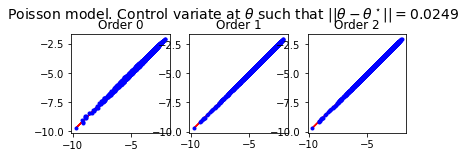

In [22]:
dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar = dens_at_thetaStar_Poisson, grad_at_thetaStar_Poisson, Hess_at_thetaStar_Poisson
theta = np.random.multivariate_normal(thetaStar, Sigma_pi, size = 1).flatten()
q_k_order0 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 0) 
q_k_order1 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 1) 
q_k_order2 = eval_q_k(theta, dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar, order = 2) 
l_k = log_density(theta, y, X)
fig, axs = plt.subplots(1, 3)
fig.suptitle(r'Poisson model. Control variate at $\theta$ such that $||\theta - \theta^\star|| = %3.4f$' % np.linalg.norm(theta - thetaStar), size = 14)
for k in range(3):
        axs[k].plot(l_k, l_k, color = 'red')
        if k == 0:
            axs[k].plot(l_k, q_k_order0, '.', color = 'blue')
            axs[k].set_title('Order 0', size = 12)
        elif k == 1:
            axs[k].plot(l_k, q_k_order1, '.', color = 'blue')
            axs[k].set_title('Order 1', size = 12)
        elif k == 2:
            axs[k].plot(l_k, q_k_order2, '.', color = 'blue')
            axs[k].set_title('Order 2', size = 12)
            
        axs[k].axis('scaled')

fig.subplots_adjust(top=1.3)
plt.show()

## 5. Subsampling MCMC
We are now ready to implement the subsampling MCMC algorithm. 

The following is the complete code for performing subsampling MCMC for the Poisson regression model using a random walk proposal. The default values are set to $m=100$ (subsample size), $G=10$ (number of blocks) and Taylor order $2$.

Try lower orders for the Taylor approximation when running the code if you want to study the effect of inaccurate control variates. With Taylor order $0$, the algorithm will get stuck. 

         Current function value: 35737.403110
         Iterations: 23
         Function evaluations: 34
         Gradient evaluations: 34
True parameter values
[ 4.3   1.6  -1.06  0.77  2.37 -0.14 -0.81 -0.67  0.45  0.98]
MAP estimates
[ 4.3   1.59 -1.05  0.78  2.37 -0.13 -0.81 -0.67  0.44  0.99]
Estimate
-35844.46249639001
True value
-35844.343479772215
Subsampling MCMC for the Poisson regression model with n = 10000, m = 100, G = 10 and Taylor order = 2
Iteration i = 1000. Acceptance prob (mean) 0.27. Time: 0.72
Iteration i = 2000. Acceptance prob (mean) 0.26. Time: 1.39
Iteration i = 3000. Acceptance prob (mean) 0.27. Time: 2.06
Iteration i = 4000. Acceptance prob (mean) 0.27. Time: 2.73
Iteration i = 5000. Acceptance prob (mean) 0.27. Time: 3.39
Iteration i = 6000. Acceptance prob (mean) 0.27. Time: 4.06
Iteration i = 7000. Acceptance prob (mean) 0.27. Time: 4.72
Iteration i = 8000. Acceptance prob (mean) 0.27. Time: 5.38
Iteration i = 9000. Acceptance prob (mean) 0.27. Time: 6.05


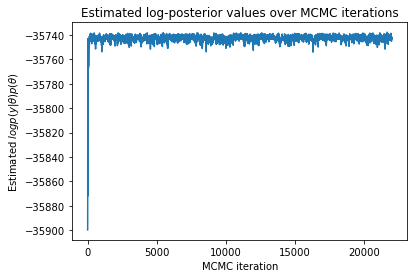

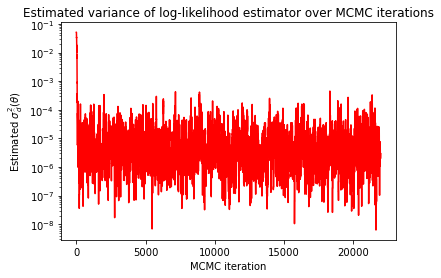

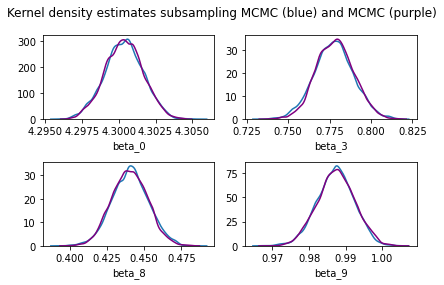

In [23]:
dens_at_thetaStar, grad_at_thetaStar, Hess_at_thetaStar = dens_at_thetaStar_Poisson, grad_at_thetaStar_Poisson, Hess_at_thetaStar_Poisson

# Define the log-posterior
log_posterior = lambda theta: log_likelihood(theta, y, X) + log_prior(theta) 
obj_func_posterior = lambda theta: -log_posterior(theta) # For maximisation purpose
grad_obj_func_posterior = grad(obj_func_posterior) # Gradient of obj_func_posterior. Computed by automatic differentiation
Hess_obj_func_posterior  = hessian(obj_func_posterior) # Hessian of obj_func_posterior. Computed by automatic differentiation

# Find starting values by optimising the log-posterior
theta_optim_start = np.zeros(10)
res_optim_posterior = minimize(obj_func_posterior, theta_optim_start, method='BFGS', jac=grad_obj_func_posterior, options={'gtol': 1e-04, 'maxiter': 1000, 'disp': True})

# Compare answers
print('True parameter values')
print(theta0)
print('MAP estimates')
MAP = res_optim_posterior.x
print(np.round(MAP, 2))

# Proposal covariance
Sigma_pi = np.linalg.inv(Hess_obj_func_posterior(MAP)) # Negative Hessian inverse evaluated at the mode
PropCov = 2.38**2/d*Sigma_pi

# Get ready for pseudo marginal Metropolis-Hastings sampling
Taylor_order = 2
N = 22000 # MCMC samples
G = 10 # Number of blocks
m = 100 # Subsample size
u_c = np.random.randint(0, n, m) 
u_block_indicators = np.hstack((np.repeat(np.arange(G-1), m/G), np.repeat(G-1, m - len(np.repeat(np.arange(G-1), m/G))))) # Splits the u into blocks

# Precomputed quantities for the control variates that do not depend on theta
# Following the notation in the slides
A = np.sum(dens_at_thetaStar) 
B = np.sum(grad_at_thetaStar, axis = 0)
C = np.sum(Hess_at_thetaStar, axis = 0)

if Taylor_order == 0:
    q_sum = lambda theta: A
elif Taylor_order == 1:
    q_sum = lambda theta: A + np.dot(B, theta - thetaStar)
elif Taylor_order == 2:
    q_sum = lambda theta: A + np.dot(B, theta - thetaStar) + 0.5*np.dot(theta - thetaStar, np.dot(C, theta - thetaStar))
else:
    raise NotImplementedError

# Storage
theta_init = MAP + sps.norm.rvs(0, 0.01, len(MAP))
samples = np.zeros((N + 1, d))
samples[0, :] = theta_init
alphas = np.zeros(N)
log_posthat_samples = np.zeros(N + 1) # Keeps the estimated value of the log-posterior (up to a normalisation constant)
sigma2_lhat_samples = np.zeros(N + 1) # Keeps the estimated variance of the log-likelihood estimator 

# Current parameter and evaluate quantities
theta_c = theta_init   
l_k_c = log_density(theta_c, y[u_c], X[u_c])  # log-densities at current theta, u
q_k_c = eval_q_k(theta_c, dens_at_thetaStar[u_c], grad_at_thetaStar[u_c], Hess_at_thetaStar[u_c], order = Taylor_order)  # control variates at current theta, u
log_posthat_c = q_sum(theta_c) + n*np.mean(l_k_c - q_k_c) + log_prior(theta_c)
sigma2_lhat_c = n**2/m*np.var(l_k_c - q_k_c, ddof = 1)
log_posthat_samples[0] = log_posthat_c
sigma2_lhat_samples[0] = sigma2_lhat_c

# Check
print('Estimate')
print(q_sum(theta_c) +  n*np.mean(l_k_c - q_k_c))
print('True value')
print(log_likelihood(theta_c, y, X))

tic = time.time()
print('Subsampling MCMC for the Poisson regression model with n = %s, m = %s, G = %s and Taylor order = %s' % (n, m, G, Taylor_order))
for i in range(1, N + 1):

    if i % 1000 == 0:
        print("Iteration i = {}. Acceptance prob (mean) {:.2f}. Time: {:.2f}".format(i , np.mean(alphas[:i]), time.time() - tic))

    # Propose parameter vector and subsample
    theta_p = np.random.multivariate_normal(theta_c, PropCov, size = 1).flatten() # flatten() to get 1-dim array 
    
    block_to_update = np.random.randint(0, G, 1)[0]
    u_p = copy.copy(u_c)
    indices_to_update = (u_block_indicators == block_to_update)
    u_p[indices_to_update] = np.random.randint(0, n, np.sum(indices_to_update)) 
    
    # 1. Evaluate log densities and control variates at theta_p, u_p. 
    # 2. Estimate the log-likelihood and the variance of the log-likelihood
    l_k_p = log_density(theta_p, y[u_p], X[u_p])  # log-densities at current theta, u
    q_k_p = eval_q_k(theta_p, dens_at_thetaStar[u_p], grad_at_thetaStar[u_p], Hess_at_thetaStar[u_p], order = Taylor_order)  # control variates at current theta, u
    log_posthat_p = q_sum(theta_p) + n*np.mean(l_k_p - q_k_p) + log_prior(theta_p)
    sigma2_lhat_p = n**2/m*np.var(l_k_p - q_k_p, ddof = 1)
    
    # log proposal densities
    log_q_p = sps.multivariate_normal.logpdf(theta_p, mean = theta_c, cov = PropCov) # log-proposal density. Symmetric (cancels), but leave for completeness           
    log_q_c = sps.multivariate_normal.logpdf(theta_c, mean = theta_p, cov = PropCov)   
    
    alpha = np.min([1, np.exp(log_posthat_p - sigma2_lhat_p/2 - log_q_p - (log_posthat_c - sigma2_lhat_c/2 - log_q_c))])
    alphas[i - 1] = alpha
    if np.random.rand() < alpha: # sample Unif(0, 1) to determine acceptance
        samples[i, :] = theta_p
        log_posthat_samples[i] = log_post_p 
        sigma2_lhat_samples[i] = sigma2_lhat_p
        # Proposed becomes current in next iteration
        theta_c, log_posthat_c, sigma2_lhat_c, log_q_c = theta_p, log_posthat_p, sigma2_lhat_p, log_q_p
    else:
        samples[i, :] = theta_c 
        log_posthat_samples[i] = log_posthat_c 
        sigma2_lhat_samples[i] = sigma2_lhat_c

matplotlib.rc('text', usetex = False)
fig, ax = plt.subplots()
ax.plot(log_posthat_samples)
ax.set(xlabel='MCMC iteration', ylabel= r'Estimated $log p(y|\theta)p(\theta)$' , 
       title= 'Estimated log-posterior values over MCMC iterations')

fig, ax = plt.subplots()
ax.plot(sigma2_lhat_samples, color = 'red')
ax.set(xlabel='MCMC iteration', ylabel= r'Estimated $\sigma^2_{\widehat{d}}(\theta)$' , 
       title= 'Estimated variance of log-likelihood estimator over MCMC iterations')
ax.set_yscale('log')

# Use 2000 as burn-in
samples = samples[2000:] 

# Effective sample size and inefficiency factors
ESS = np.zeros(samples.shape[1])
for j in range(samples.shape[1]):
    ESS[j] = effective_sample_size(samples[:, j])    
IF = samples.shape[0]/ESS
   
print("Mean ESS: {:.2f}. Median ESS: {:.2f}. Min ESS: {:.2f}. Max ESS: {:.2f}".format(np.mean(ESS), np.median(ESS), np.min(ESS), np.max(ESS)))
print("Mean IF : {:.2f}. Median IF : {:.2f}. Min IF : {:.2f}. Max IF : {:.2f}".format(np.mean(IF), np.median(IF), np.min(IF), np.max(IF)))
RCT = (n*IF_MCMC_RW)/(m*IF)
print("RCT (vs full data) : {:.2f}. Median RCT : {:.2f}. Min RCT : {:.2f}. Max RCT : {:.2f}".format(np.mean(RCT), np.median(RCT), np.min(RCT), np.max(RCT)))

# KDE estimates for selected four parameters (0, 1, ... , d - 1)
params_to_plot = [0, 3, 8, 9]
assert(len(params_to_plot) == 4)
param_names = ['beta_%s' % item for item in range(d)]    

# The following codes plots the kernel density estimates of the subsampling MCMC(assuming they are stored in samples) 
# and the RW sampler (assuming they are stored in samples_RW)    
fig, axs = plt.subplots(2, 2)
fig.suptitle('Kernel density estimates subsampling MCMC (blue) and MCMC (purple)')
k = 0
for i in range(2):
    for j in range(2):
        # Subsampling MCMC with a RW
        min_x = np.min(samples[:, params_to_plot[k]])
        max_x = np.max(samples[:, params_to_plot[k]])
        x_grid = np.linspace(min_x, max_x, 500)
        kde = sm.nonparametric.KDEUnivariate(samples[:, params_to_plot[k]]) # kernel density for each parameter
        kde.fit() 
        axs[i, j].plot(kde.support, kde.density)
        
        # RW Metropolis-Hastings (Full data)
        min_x = np.min(samples_RW[:, params_to_plot[k]])
        max_x = np.max(samples_RW[:, params_to_plot[k]])
        x_grid = np.linspace(min_x, max_x, 500)
        kde = sm.nonparametric.KDEUnivariate(samples_RW[:, params_to_plot[k]]) # kernel density for each parameter
        kde.fit() 
        axs[i, j].plot(kde.support, kde.density, color = 'purple')
        axs[i, j].set_ylim(ymin = 0)
        axs[i, j].set(xlabel = param_names[params_to_plot[k]])
        k = k + 1

fig.tight_layout()        
fig.subplots_adjust(top=0.88)
plt.show()        